# 2 - Simple regression model in TensorFlow 2.0... probabilistically.

Let's get some data from the cars data set!

In [3]:
import pathlib
from typing import Any, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

print(tf.__version__)
tf.get_logger().setLevel('ERROR')

2.0.0


In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/anglin/.keras/datasets/auto-mpg.data'

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Now that we have some data, we need to go about cleaning it.

In [6]:
# Drop NA values
dataset = dataset.dropna()

In [7]:
# We need to turn origin into a one-hot encoded vector.

origin = dataset.pop('Origin')

In [8]:
dataset['USA'] = (origin == 1) * 1.0  # Cast Series to float
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [9]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("MPG") 
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


Split the data set into an 80/20 train/test division.

In [11]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

Normal-transform data set for use in a regression network.

In [12]:
def norm(x: pd.DataFrame) -> pd.DataFrame:
    """Norm all columns to zero mean and unit standard deviation."""
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# Do it probabilistically!

Going to replace the first `Dense` layer with one that's probabilistic.

In [13]:
def build_model():
    model = keras.Sequential([
        tfp.layers.DenseVariational(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1),
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

`DenseVariational`? This is a vanilla densely-connected neural network layer that, rather than fitting point estimates, fits distributions over its weights using _variational inference_. Variational inference as a topic is beyond the scope of this talk, but for now let's consider it a way to update prior Bayesian beliefs about a distribution in response to observed data that's more computationally efficient than Markov Chain Monte Carlo sampling.

For further research, I recommend starting with this overview by Volodymyr Kuleshov and Stefano Ermon with the Stanford Probabilistic Graphical Modeling course.

In [1]:
%%HTML
<iframe src="https://ermongroup.github.io/cs228-notes/inference/variational/" width="900" height="500"></iframe>



And it's just that easy.

In [14]:
model = build_model()

TypeError: __init__() missing 2 required positional arguments: 'make_posterior_fn' and 'make_prior_fn'

Well, maybe not quite that easy.

## Specify trainable priors and posterior functions.

In order to work with the `DenseVariational` layer, we need to provide it with a function to make its posterior (learned) distribution of weights and a prior distribution to apply to the weights in the absence of any observed data.


Our `make_posterior_fn` -- must take a kernel_size, bias_size, and data type, return a callable that creates
a tfd.Distribution instance. In our case, it's going to execute the mean field approximation for variational inference -- again, this topic is beyond the scope of today's talk, but you are encouraged to research more, perhaps starting [here](https://www.cs.cmu.edu/~epxing/Class/10708-17/notes-17/10708-scribe-lecture13.pdf).

In [15]:
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: Any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

For our `make_prior_fn`, we'll define a normal distribution with a _trainable_ mean -- that is, we won't place any expectations on the mean of our prior for the weights in our `DenseVariational` layer, and we'll allow that parameter to be learned from the data. Our prior on the standard deviation of the layer weights is 1.

In [16]:
def prior_trainable(kernel_size: int, bias_size: int, dtype: Any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])

Now that we've defined our make_posterior_fn and make_prior_fn, we can pass them in as named arguments to the `DenseVariational` layer as a drop-in replacement for the previous `Dense` layer.

In [17]:
def build_model():
    model = keras.Sequential([
        tfp.layers.DenseVariational(64, activation='relu', 
                                input_shape=[len(train_dataset.keys())], 
                                make_posterior_fn=posterior_mean_field, 
                                make_prior_fn=prior_trainable),
        layers.Dense(64, activation='relu'),
        layers.Dense(1),
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

model = build_model()

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 64)                1920      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
_________________________________________________________________


Note the increased number of parameters in the first layer vs our previous try. The non-variational version of this model had 640 parameters, so we're training triple the number with this variational layer.

Let's try our previous exercise of predicting an example batch of training data through the untrained model.

In [19]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 6.08518  ],
       [ 7.152992 ],
       [ 3.3633397],
       [ 8.244967 ],
       [ 8.667573 ],
       [ 4.385354 ],
       [ 9.5241   ],
       [11.070632 ],
       [ 3.3195922],
       [ 7.268409 ]], dtype=float32)

And if we do it again, we should get the same results.

In [20]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[2.666662 ],
       [1.7021008],
       [7.7906322],
       [2.6414912],
       [2.4541183],
       [3.2705355],
       [3.0763304],
       [7.3763165],
       [2.670927 ],
       [2.0273066]], dtype=float32)

They're different! The predictions through the untrained model aren't the same, even though they're going through the same network. Let's take a look at those network layers.

In [22]:
model.layers[0]

Ok, the first layer is this `DenseVariational` layer from `tensorflow_probability`. What's happening here is that the model isn't learning weights for that layer (and hasn't initialized them). Rather, it's trying to learn _distributions_ over the weights. We've initialized these to be normal distributions with mean 0 and standard deviation 1, and each time we pass a prediction through the network, the actual weights used for that prediction are each _random draws_ from the distributions that describe them.

Again, this network is completely untrained right now, so let's let it learn something.

In [23]:
class PrintDot(keras.callbacks.Callback):
    """
    Display training progress by printing a single dot for 
    each completed epoch.
    """
    def on_epoch_end(self, epoch, logs) -> None:
        """
        `on_epoc_end` hook to take the epoch number and logs.
        This will run whenever the training loop finishes an epoch.
        """
        if epoch % 100 == 0: 
            print('')
        print('.', end='')

        
EPOCHS = 1_000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,16.984921,2.774518,15.073513,16.308543,2.771710,13.076904,995
996,20.361731,3.060756,16.387224,13.847049,2.930822,11.916781,996
997,15.117471,2.744835,12.815410,19.417405,3.315727,17.104467,997
998,16.563783,2.823744,14.471605,25.084227,3.201930,18.669933,998
999,15.901956,2.705328,12.431559,15.265798,2.837383,12.711079,999


Our errors are a bit higher than they were with the previous network, but note the difference between the training and validation losses. They're very close to one another, whereas before we were hopelessly overfit.

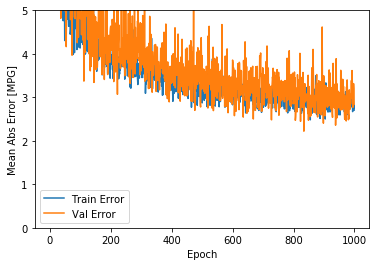

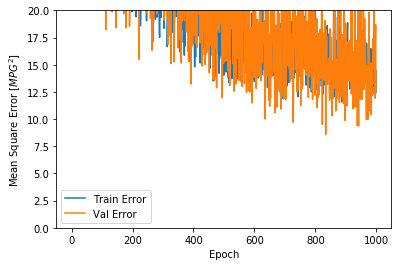

In [25]:
def plot_history(hist: pd.DataFrame) -> None:
    """
    Plot training vs validation MAE and MSE over epoch.
    """
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(hist)

That's actually not very helpful anymore, because our training and validation errors are right on top of one another. Let's increase the y-axis scale to zoom out a bit and decrease the transparency so we can actually see what's going on.

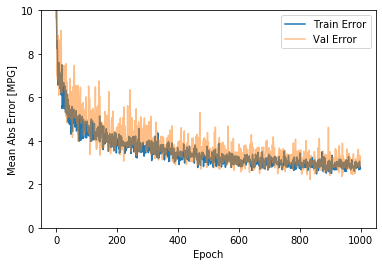

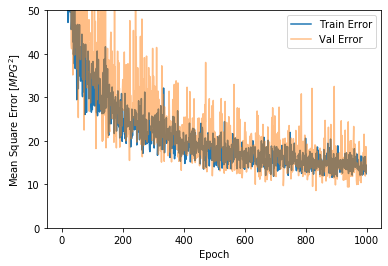

In [26]:
def plot_history(hist: pd.DataFrame) -> None:
    """
    Plot training vs validation MAE and MSE over epoch.
    """

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], alpha=0.5,
           label = 'Val Error')
    plt.ylim([0,10])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], alpha=0.5,
           label = 'Val Error')
    plt.ylim([0,50])
    plt.legend()
    plt.show()


plot_history(hist)

How fascinating! Even after 1,000 epochs, we're not yet overfit. Our training and validation errors are tracking together almost exactly.

Let's check out our model predictions vs true values of MPG.

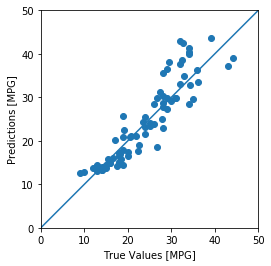

In [27]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

And what if we do it again?

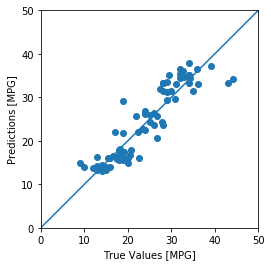

In [28]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

The dots moved! TensorFlow Probability is transparently drawing new samples from the distributions we've trained over our network's weights, and it's interacting completely seamlessly with the `tf.keras.Model` predict method.

We can even ask the model to give us a sample of predictions from each incoming x and use that to give us quantified estimates of its uncertainty.

In [29]:
# Use a list comprehension to predict over each test instance 100 times.
yhats = [model.predict(normed_test_data).flatten() for _ in range(100)]

In [30]:
df = pd.DataFrame(yhats).T
df['y'] = test_labels.values

In [31]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,y
0,15.751209,16.595617,18.560678,15.596846,11.949699,15.205064,15.439437,18.523129,16.628700,18.006653,...,13.880723,19.228233,20.946968,14.297537,12.082489,18.416697,16.746645,17.215508,15.361007,15.0
1,15.153145,15.832514,16.902466,13.015862,10.913985,13.608974,13.391296,15.452138,18.572046,15.119386,...,13.313794,17.189085,13.611214,13.512843,9.900172,14.729367,14.893866,18.417826,13.829511,10.0
2,14.961707,14.199581,14.975321,12.848340,11.523496,14.831738,12.235961,15.158460,18.867027,14.544644,...,14.768669,16.450865,13.258037,14.551356,9.877278,14.131652,14.707356,19.337301,14.137352,9.0
3,25.914770,23.114048,23.280693,29.083698,25.293650,22.311062,25.689106,25.007269,24.890644,24.294533,...,26.608482,25.399809,25.476032,27.839798,25.110832,24.261343,27.486130,26.498646,25.685760,25.0
4,15.970424,17.867006,17.167374,18.876635,16.394726,18.324190,16.482258,19.507257,16.776211,16.457054,...,17.628393,20.048824,19.906805,18.312702,18.510475,20.094852,16.363806,17.421238,17.157375,19.0


Great! Now, what we want in order to examine this is every predicted y-hat along with its true y-value in a tuple. Here's a somewhat hacky way to accomplish that using `itertools.chain.from_iterable`.

In [32]:
import itertools

sample_preds = list(itertools.chain.from_iterable([[(j, x[-1]) for j in x if j != x[-1]] for x in df.values]))

In [33]:
sample_preds[:15]

[(15.751209259033203, 15.0),
 (16.595617294311523, 15.0),
 (18.560678482055664, 15.0),
 (15.596845626831055, 15.0),
 (11.949699401855469, 15.0),
 (15.205063819885254, 15.0),
 (15.439436912536621, 15.0),
 (18.523128509521484, 15.0),
 (16.628700256347656, 15.0),
 (18.00665283203125, 15.0),
 (13.020134925842285, 15.0),
 (13.250887870788574, 15.0),
 (16.48166275024414, 15.0),
 (19.579206466674805, 15.0),
 (15.56988525390625, 15.0)]

Alright! Now let's plot these as we just did for the single-batch predictions.

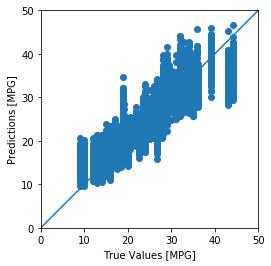

In [34]:
a = plt.axes(aspect='equal')
plt.scatter([x[1] for x in sample_preds], [x[0] for x in sample_preds])
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Overlapping plot points in `matplotlib` are hurting us. Let's add some transparency, so we can see the relative frequency of each point.

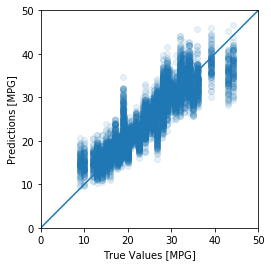

In [35]:
a = plt.axes(aspect='equal')
plt.scatter([x[1] for x in sample_preds], [x[0] for x in sample_preds], alpha=0.1)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Here, our model is actually _telling us_ where it's not sure, indicated by the range of predictions that it's outputting for each of the input __x__'s. We can confirm visually that the model is less confidednt as we move up in the predicted MPG and in fact consistently underpredicts the true value as we get to the higher ranges.

We can also run our same error analysis from earlier, just using a single random draw from the weight distributions to make a model prediction.

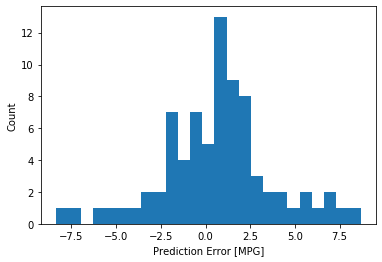

In [36]:
test_predictions = model.predict(normed_test_data).flatten()
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

What's more, every time we run this, we'll get a different set of predictions (and therefore a different set of errors).

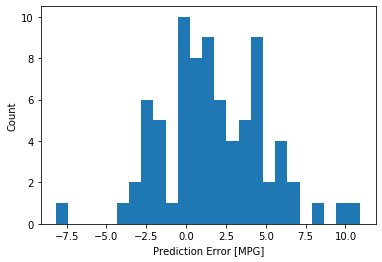

In [37]:
test_predictions = model.predict(normed_test_data).flatten()
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Instead of calling that predict routine, why don't we use our sample of 100 predictions from earlier.

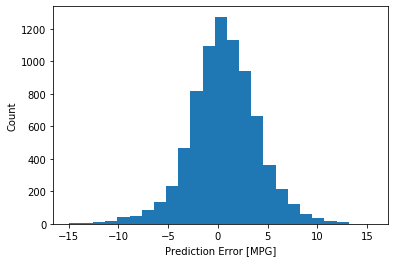

In [38]:
error = [x[0] - x[1] for x in sample_preds]
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Now we're starting to see that normal distribution manifest itself. This is because we're now conducting a true Monte Carlo sample from the distributions that describe each of the model weights every time we make a prediction, and therefore we have transparent understanding of the root uncertainty the model contains.

Moreover, because our model hasn't shown the tendency to overfit, we can keep training it!

In [39]:
history2 = model.fit(
    normed_train_data, 
    train_labels,
    epochs=2_000, 
    validation_split = 0.2, 
    verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [40]:
hist2 = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch
hist2['epoch'] = hist2['epoch'] + EPOCHS
hist2.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
1995,12.221927,2.258037,9.660421,15.185131,3.010659,14.911633,2995
1996,13.961404,2.761640,13.532859,17.169139,2.807293,12.170686,2996
1997,15.776743,2.547677,12.215005,13.732301,2.422819,9.221044,2997
1998,14.050060,2.336254,10.815164,15.228209,2.390776,10.105352,2998
1999,13.781770,2.586059,11.737844,20.004274,2.814895,15.103965,2999


In [42]:
combined_hist = pd.concat([hist, hist2])

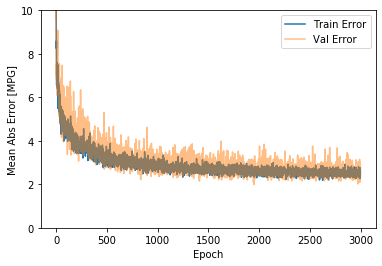

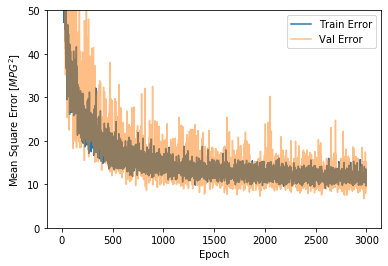

In [43]:
plot_history(combined_hist)

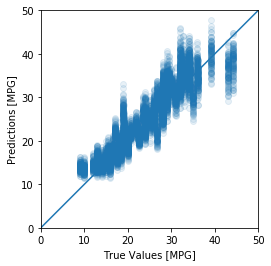

In [44]:
# Use a list comprehension to predict over each test instance 100 times.
yhats = [model.predict(normed_test_data).flatten() for _ in range(100)]

df = pd.DataFrame(yhats).T
df['y'] = test_labels.values

sample_preds = list(itertools.chain.from_iterable([[(j, x[-1]) for j in x if j != x[-1]] for x in df.values]))

a = plt.axes(aspect='equal')
plt.scatter([x[1] for x in sample_preds], [x[0] for x in sample_preds], alpha=0.1)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

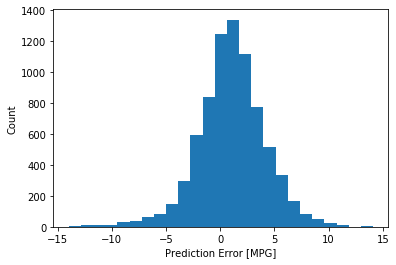

In [45]:
error = [x[0] - x[1] for x in sample_preds]
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

### Takeaways:
- TensorFlow Probability offers a `layers` submodule with a selection of `tf.keras`-compatible neural network layers that are _probabilistic_.
- These layers interoperate cleanly with existing neural network architectures (up to a point -- sometimes they need explicit priors or other arguments to be provided for them).
- Probabilistic neural networks (those with probabilistic layers specifying distributions over their weights) are substantially less prone to overfitting than neural networks that merely fit point estimates.
- The `predict` method on these models pulls a _random draw_ from the distributions that specify the weights of the model.
- If we run many predictions, we draw a Monte Carlo sample from the model and obtain true estimates of its _uncertainty_.

The point on probabilistic neural networks being less prone to overfitting is a good one that's been explored in some depth. It's beyond the scope of this talk, but I refer the interested reader to _Gal & Ghahramani (2016)_, below.

In [2]:
%%HTML
<iframe src="https://arxiv.org/pdf/1506.02142.pdf" width="900" height="1000"></iframe>
